In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


     t       price  position  entry_price    reward    equity  realized_pnl  unrealized_pnl  opened  closed  exec_price  pnl_trade
0    1  105.877853         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
1    2  104.817537         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
2    3  103.681246         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
3    4  102.486899         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
4    5  101.253332         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
5    6  100.000000         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
6    7   98.746668         0     0.000000  0.000000  0.000000      0.000000        

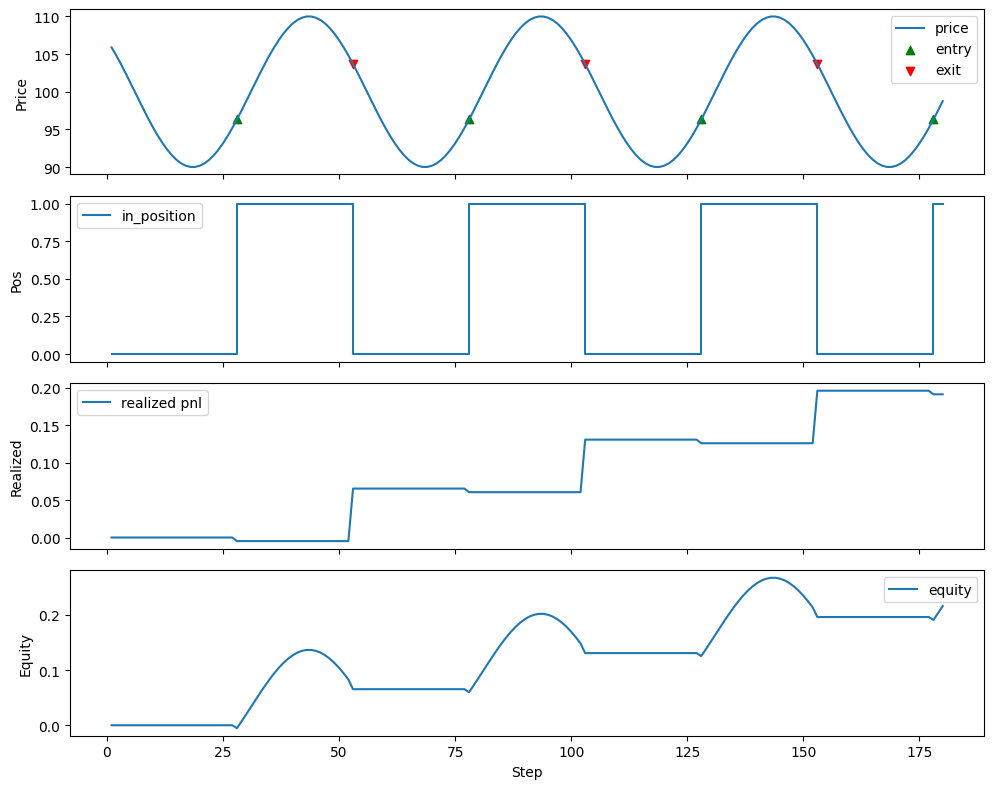

In [4]:
# Проверка среды на синтетических данных LONG

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig


def generate_sine_data(n=200, fast_window=5, slow_window=20):
    """Generate sinusoidal price data with moving averages and signals."""
    t = np.arange(n)
    price = 100 + 10 * np.sin(2 * np.pi * t / 50)
    df = pd.DataFrame({'close': price})
    df['fast_ma'] = df['close'].rolling(window=fast_window).mean()
    df['slow_ma'] = df['close'].rolling(window=slow_window).mean()
    df.dropna(inplace=True)
    fast = df['fast_ma']
    slow = df['slow_ma']
    signal = np.zeros(len(df), dtype=int)
    signal[(fast > slow) & (fast.shift(1) <= slow.shift(1))] = 1
    signal[(fast < slow) & (fast.shift(1) >= slow.shift(1))] = -1
    df['signal'] = signal
    return df.reset_index(drop=True)


def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['signal']:
        action = 0
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.00005,         # без комиссии
    spread=0.0005,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

#проверка лонгов
df = generate_sine_data()
environment = BacktestEnv(df, feature_cols=['fast_ma', 'slow_ma'], cfg = LONG_CONFIG)
sim = run_backtest(df, environment)
logs = sim.logs()
print(logs.head(50).to_string())
print('Метрики: ')
print(sim.metrics_report())
fig = sim.plot()


     t       price  position  entry_price    reward    equity  realized_pnl  unrealized_pnl  opened  closed  exec_price  pnl_trade
0    1  105.877853         0     0.000000 -0.000000  0.000000      0.000000        0.000000   False   False    0.000000   0.000000
1    2  104.817537         0     0.000000 -0.000000  0.000000      0.000000        0.000000   False   False    0.000000   0.000000
2    3  103.681246        -1   103.681246 -0.005184 -0.005184     -0.005184       -0.000000    True   False  103.681246   0.000000
3    4  102.486899        -1   103.681246  0.011519  0.006335     -0.005184        0.011519   False   False    0.000000   0.000000
4    5  101.253332        -1   103.681246  0.012036  0.018372     -0.005184        0.023417   False   False    0.000000   0.000000
5    6  100.000000        -1   103.681246  0.012378  0.030750     -0.005184        0.035505   False   False    0.000000   0.000000
6    7   98.746668        -1   103.681246  0.012533  0.043283     -0.005184        

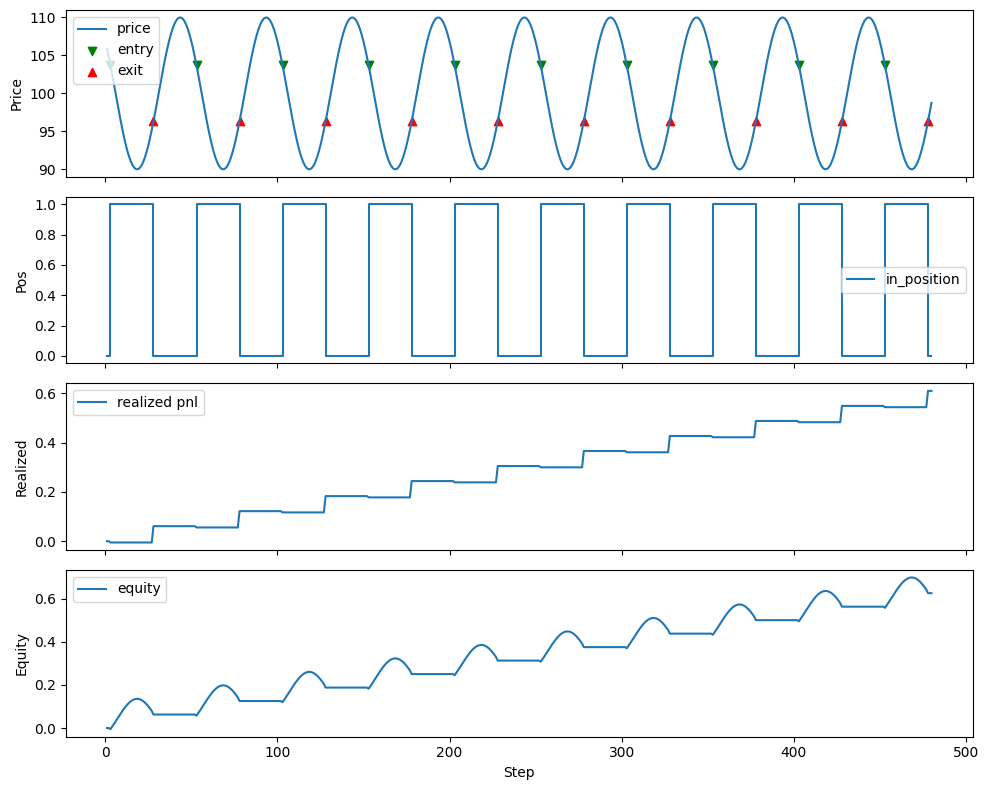

In [5]:
# Проверка среды на синтетических данных SHORT

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig


def generate_sine_data(n=500, fast_window=5, slow_window=20):
    """Generate sinusoidal price data with moving averages and signals."""
    t = np.arange(n)
    price = 100 + 10 * np.sin(2 * np.pi * t / 50)
    df = pd.DataFrame({'close': price})
    df['fast_ma'] = df['close'].rolling(window=fast_window).mean()
    df['slow_ma'] = df['close'].rolling(window=slow_window).mean()
    df.dropna(inplace=True)
    fast = df['fast_ma']
    slow = df['slow_ma']
    signal = np.zeros(len(df), dtype=int)
    signal[(fast < slow) & (fast.shift(1) >= slow.shift(1))] = 1
    signal[(fast > slow) & (fast.shift(1) <= slow.shift(1))] = -1
    df['signal'] = signal
    return df.reset_index(drop=True)


def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['signal']:
        action = 0
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

SORT_CONFIG = EnvConfig(
    mode=-1,          # работаем только от длинной позиции
    fee=0.00005,         # без комиссии
    spread=0.000,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

#проверка лонгов
df = generate_sine_data()
environment = BacktestEnv(df, feature_cols=['fast_ma', 'slow_ma'], cfg = SORT_CONFIG)
sim = run_backtest(df, environment)
logs = sim.logs()
print(logs.head(50).to_string())
print(sim.metrics_report())
fig = sim.plot()


     t    price  position  entry_price    reward    equity  realized_pnl  unrealized_pnl  opened  closed  exec_price  pnl_trade
0    1  0.08958         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
1    2  0.08963         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
2    3  0.08962         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
3    4  0.08974         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
4    5  0.08977         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
5    6  0.08980         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
6    7  0.08982         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False

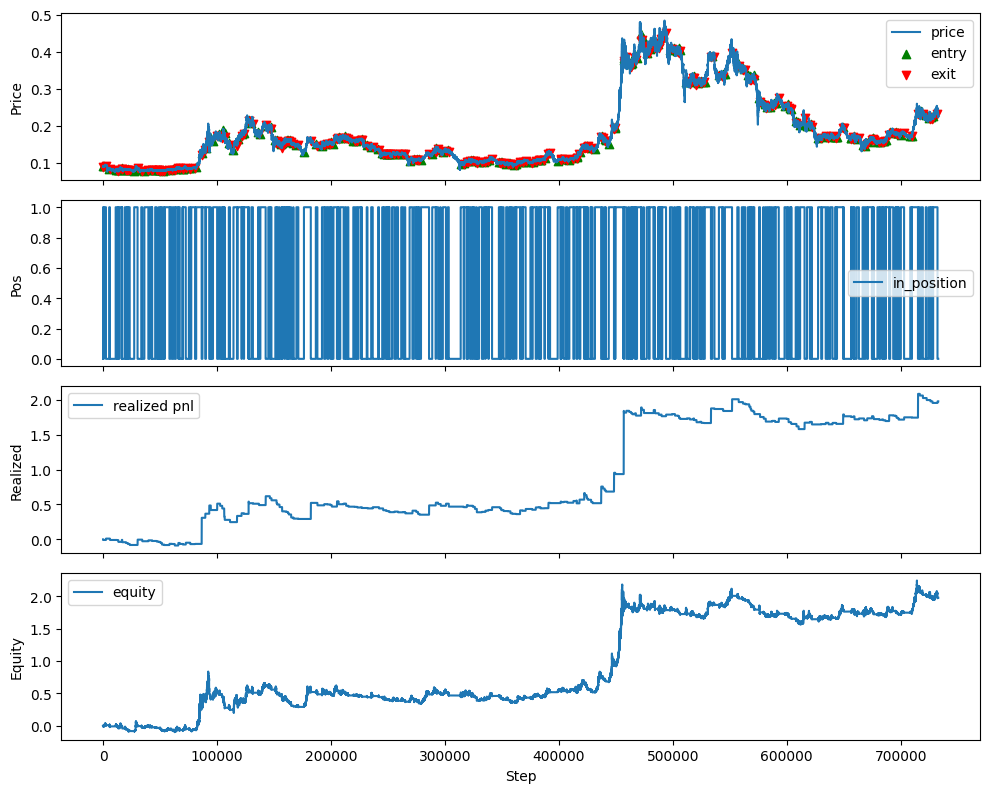

In [12]:
import joblib
from numba import njit
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig

PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"

df = joblib.load(PATH_TO_DATA).iloc[-1000000:]

open_px  = df['Open'].to_numpy(np.float64)
high_px  = df['High'].to_numpy(np.float64)
low_px   = df['Low'].to_numpy(np.float64)
close_px = df['Close'].to_numpy(np.float64)
volum_px = df['Volume'].to_numpy(np.float64)


@njit(cache=False)
def _wilder_smooth(arr, period):
    n = arr.shape[0]
    out = np.empty(n, dtype=np.float64)
    if period <= 0 or period > n:
        for i in range(n):
            out[i] = np.nan
        return out
    s = 0.0
    for i in range(period):
        s += arr[i]
    out[period-1] = s
    for i in range(period, n):
        s = out[i-1] - (out[i-1] / period) + arr[i]
        out[i] = s
    for i in range(period-1):
        out[i] = np.nan
    return out

@njit(cache=False)
def ema_numba(x, period):
    n = x.shape[0]
    out = np.empty(n, dtype=np.float64)
    if period <= 0:
        for i in range(n):
            out[i] = np.nan
        return out
    alpha = 2.0 / (period + 1.0)
    out[0] = x[0]
    for i in range(1, n):
        out[i] = out[i-1] + alpha * (x[i] - out[i-1])
    return out

@njit(cache=False)
def adx_numba(high, low, close, period):
    n = close.shape[0]
    plus_dm = np.zeros(n, dtype=np.float64)
    minus_dm = np.zeros(n, dtype=np.float64)
    tr = np.zeros(n, dtype=np.float64)

    for i in range(1, n):
        up_move = high[i] - high[i-1]
        down_move = low[i-1] - low[i]
        plus_dm[i] = up_move if (up_move > down_move and up_move > 0.0) else 0.0
        minus_dm[i] = down_move if (down_move > up_move and down_move > 0.0) else 0.0

        hl = high[i] - low[i]
        hc = abs(high[i] - close[i-1])
        lc = abs(low[i] - close[i-1])
        tr[i] = max(hl, hc, lc)

    tr_s = _wilder_smooth(tr, period)
    plus_dm_s = _wilder_smooth(plus_dm, period)
    minus_dm_s = _wilder_smooth(minus_dm, period)

    plus_di = np.empty(n, dtype=np.float64)
    minus_di = np.empty(n, dtype=np.float64)
    for i in range(n):
        if np.isnan(tr_s[i]) or tr_s[i] == 0.0:
            plus_di[i] = np.nan
            minus_di[i] = np.nan
        else:
            plus_di[i] = 100.0 * (plus_dm_s[i] / tr_s[i])
            minus_di[i] = 100.0 * (minus_dm_s[i] / tr_s[i])

    dx = np.empty(n, dtype=np.float64)
    for i in range(n):
        s = plus_di[i] + minus_di[i]
        if np.isnan(plus_di[i]) or np.isnan(minus_di[i]) or s == 0.0:
            dx[i] = np.nan
        else:
            dx[i] = 100.0 * (abs(plus_di[i] - minus_di[i]) / s)

    adx = np.empty(n, dtype=np.float64)
    for i in range(n):
        adx[i] = np.nan
    if period <= 0 or period > n:
        return adx  # и +DI/–DI уже посчитаны

    # среднее первых 'period' DX
    s = 0.0
    cnt = 0
    start = -1
    for i in range(n):
        if not np.isnan(dx[i]):
            s += dx[i]; cnt += 1
            if cnt == period:
                adx[i] = s / period
                start = i + 1
                break
    if start != -1:
        prev = adx[start-1]
        for i in range(start, n):
            if np.isnan(dx[i]):
                adx[i] = np.nan
            else:
                prev = ((prev * (period - 1)) + dx[i]) / period
                adx[i] = prev
    return adx


df['EMA_Fast'] = ema_numba(close_px, 750)
df['EMA_Slow'] = ema_numba(close_px, 1000)
df['ADX'] = adx_numba(high_px, low_px, close_px, 14)

# Добавляем сигнал референс стратегии
buy_sig  = (df['EMA_Fast'] > df['EMA_Slow']) & (df['Close'] > df['EMA_Fast']) & (df['ADX'] > 20)
sell_sig = (df['EMA_Fast'] < df['EMA_Slow']) & (df['Close'] < df['EMA_Fast']) & (df['ADX'] > 20)
df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)


def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['Signal_Rule']:
        action = 0
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.00005,         # без комиссии
    spread=0.0005,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

#проверка лонгов
environment = BacktestEnv(df, feature_cols=['EMA_Fast', 'EMA_Slow'], cfg = LONG_CONFIG, price_col='Open')
sim = run_backtest(df, environment)
logs = sim.logs()
print(logs.head(50).to_string())
print('Метрики: ')
print(sim.metrics_report())
fig = sim.plot()

In [9]:
# @title Запуск тестов из папки tests
%cd "/content/drive/MyDrive/stocks/pretrained_rl_ppo"
!pytest -q



/content/drive/MyDrive/stocks/pretrained_rl_ppo
..................                                                       [100%]
18 passed in 3.29s
